# How Accurate is the S5 data?

In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
# colormaps = https://matplotlib.org/cmocean/
import cmocean
import matplotlib.pyplot as plt
import geopandas as gpd
from typing import List, Tuple, Dict, Union, Optional

import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 100

import os

# set the working directory
current_path = Path('.').resolve()
if current_path == Path('/home/tommy/ml_drought/notebooks/draft'):
    os.chdir(current_path.parents[1].as_posix())

current_path = Path('.').resolve()
assert current_path.name == "ml_drought"

%load_ext autoreload
%autoreload 2

In [44]:
from scripts.utils import get_data_path
from src.engineer import Engineer
from src.utils import get_ds_mask
from src.utils import drop_nans_and_flatten

In [3]:
data_dir = get_data_path()

# Load the S5 data

In [72]:
from src.engineer import Engineer

engineer = Engineer(
    get_data_path(), experiment="one_month_forecast", process_static=True
)
e = engineer.engineer_class
data = e._make_dataset(static=False)
data

Processing /cats/datastore/data/interim/VCI_preprocessed/data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_1_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_2_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_3_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/volumetric_soil_water_layer_4_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/potential_evaporation_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/total_precipitation_data_india.nc
Processing /cats/datastore/data/interim/reanalysis-era5-land-monthly-means_preprocessed/2m_temperature_data_india.nc
Processing /cats/datastore/data/interi

<xarray.Dataset>
Dimensions:        (lat: 304, lon: 305, time: 242)
Coordinates:
  * time           (time) datetime64[ns] 2000-02-29 2000-03-31 ... 2020-03-31
  * lon            (lon) float32 67.3 67.4 67.5 67.6 ... 97.4 97.5 97.6 97.7
  * lat            (lat) float32 36.0 35.9 35.8 35.7 35.6 ... 6.0 5.9 5.8 5.7
Data variables:
    VCI            (time, lat, lon) float64 ...
    swvl1          (time, lat, lon) float32 ...
    swvl2          (time, lat, lon) float32 ...
    swvl3          (time, lat, lon) float32 ...
    swvl4          (time, lat, lon) float32 ...
    pev            (time, lat, lon) float32 ...
    tp             (time, lat, lon) float32 ...
    t2m            (time, lat, lon) float32 ...
    e              (time, lat, lon) float32 ...
    t2m_std_1      (time, lat, lon) float64 ...
    t2m_mean_1     (time, lat, lon) float64 ...
    t2m_std_2      (time, lat, lon) float64 ...
    t2m_mean_2     (time, lat, lon) float64 ...
    t2m_std_3      (time, lat, lon) float64 ...
    t2m_mean_3     (time, lat, lon) float64 ...
    erate_std_1    (time, lat, lon) float64 ...
    erate_mean_1   (time, lat, lon) float64 ...
    erate_std_2    (time, lat, lon) float64 ...
    erate_mean_2   (time, lat, lon) float64 ...
    erate_std_3    (time, lat, lon) float64 ...
    erate_mean_3   (time, lat, lon) float64 ...
    tprate_std_1   (time, lat, lon) float64 ...
    tprate_mean_1  (time, lat, lon) float64 ...
    tprate_std_2   (time, lat, lon) float64 ...
    tprate_mean_2  (time, lat, lon) float64 ...
    tprate_std_3   (time, lat, lon) float64 ...
    tprate_mean_3  (time, lat, lon) float64 ...

In [73]:
seamask = get_ds_mask(data["VCI"])
data = data.where(~seamask)

# Normalize all data

In [78]:
norm, norm_dict = normalize_xr(data)

# Check how the data varies

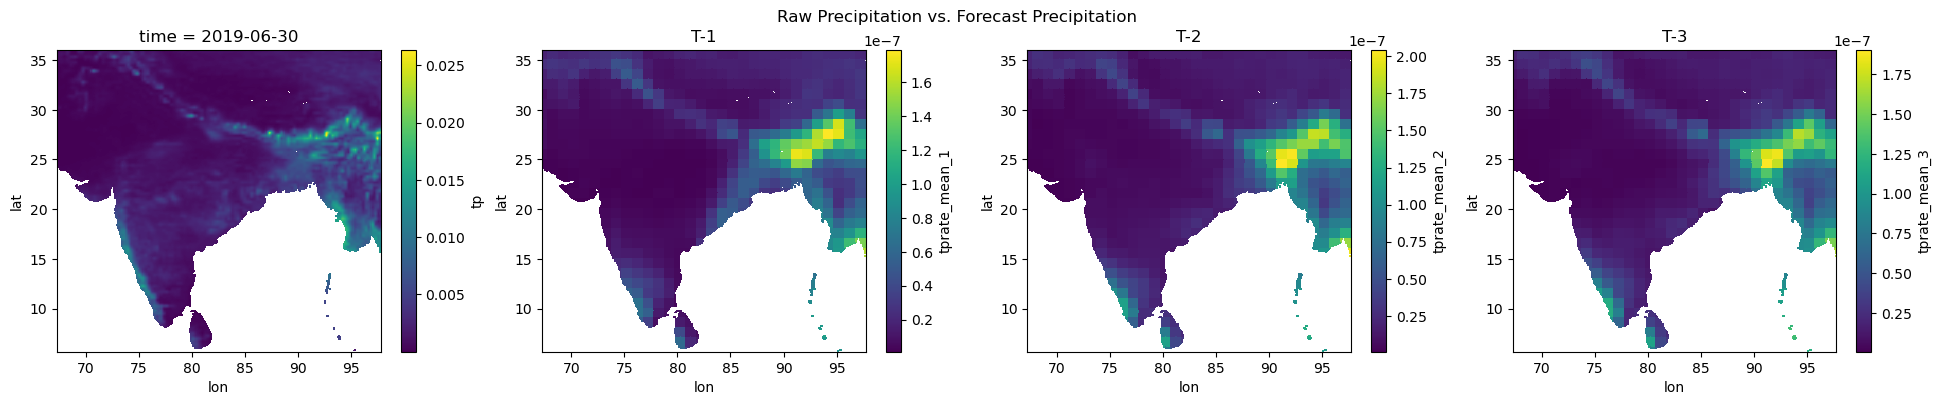

In [87]:
fig, axs = plt.subplots(1, 4, figsize=(6*4, 4))
data.tp.isel(time=-10).plot(ax=axs[0])
data.tprate_mean_1.isel(time=-10).plot(ax=axs[1])
axs[1].set_title("T-1")
data.tprate_mean_2.isel(time=-10).plot(ax=axs[2])
axs[2].set_title("T-2")
data.tprate_mean_3.isel(time=-10).plot(ax=axs[3])
axs[3].set_title("T-3")
fig.suptitle("Raw Precipitation vs. Forecast Precipitation");

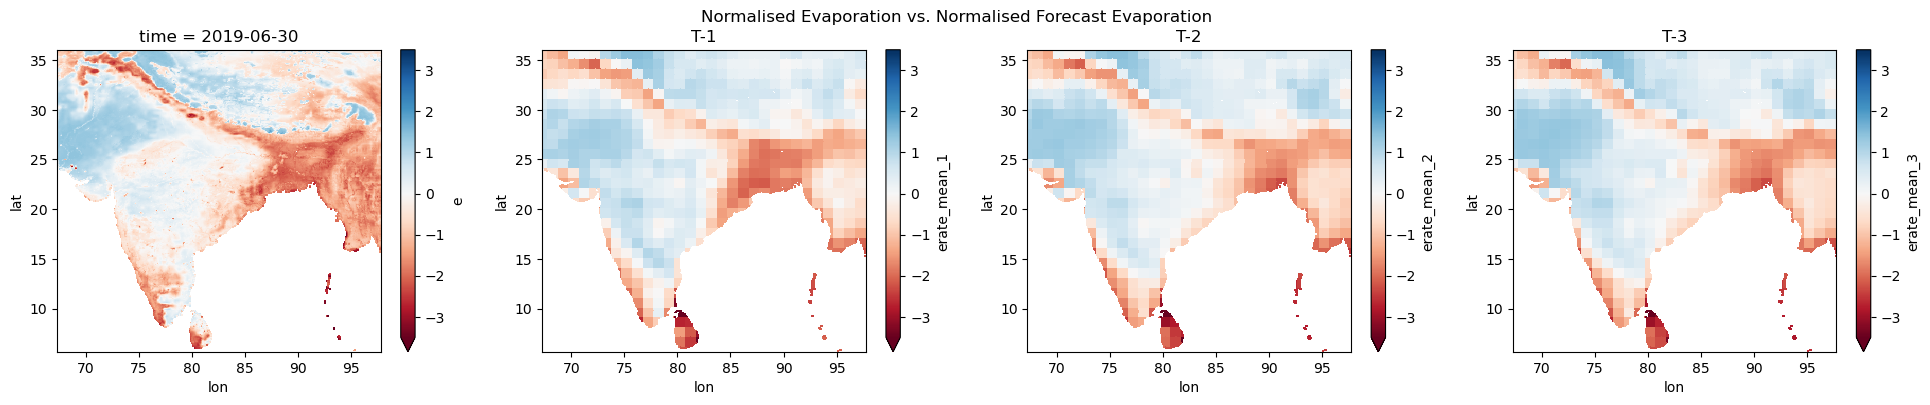

In [98]:
kwargs = {"vmin": -3.5, "vmax": 3.5, "cmap": "RdBu"}
fig, axs = plt.subplots(1, 4, figsize=(6*4, 4))
norm.e.isel(time=-10).plot(ax=axs[0], **kwargs)
norm.erate_mean_1.isel(time=-10).plot(ax=axs[1], **kwargs)
axs[1].set_title("T-1")
norm.erate_mean_2.isel(time=-10).plot(ax=axs[2], **kwargs)
axs[2].set_title("T-2")
norm.erate_mean_3.isel(time=-10).plot(ax=axs[3], **kwargs)
axs[3].set_title("T-3")
fig.suptitle("Normalised Evaporation vs. Normalised Forecast Evaporation");

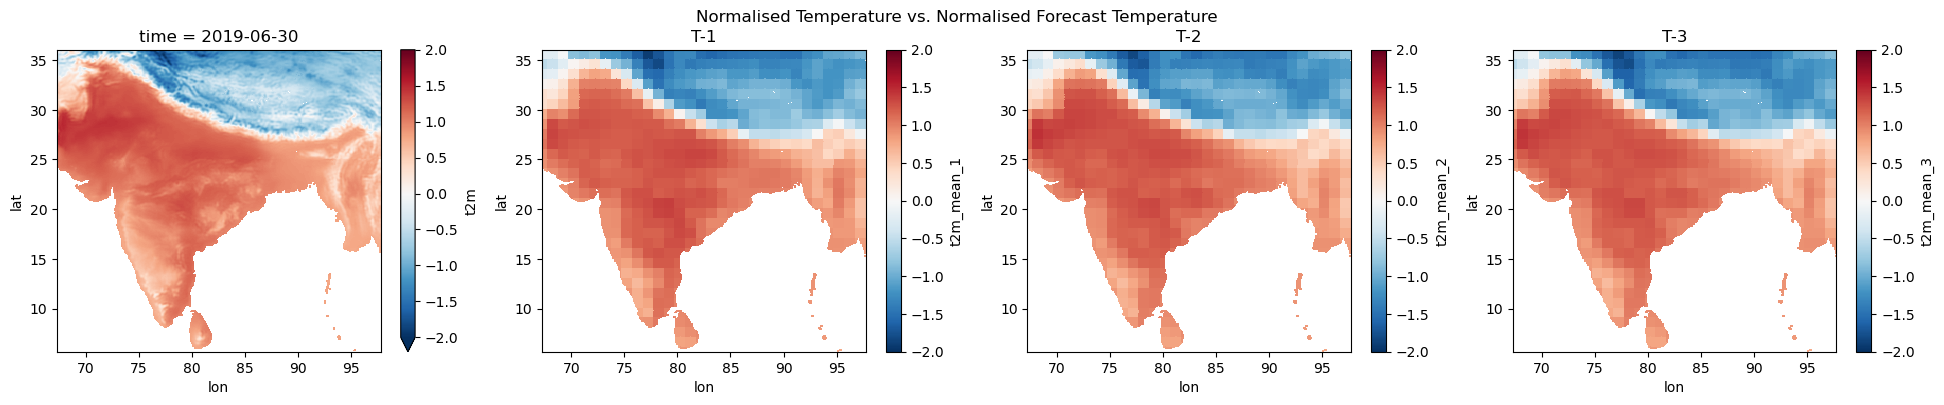

In [94]:
fig, axs = plt.subplots(1, 4, figsize=(6*4, 4))
norm.t2m.isel(time=-10).plot(ax=axs[0], vmin=-2, vmax=2, cmap="RdBu_r")
norm.t2m_mean_1.isel(time=-10).plot(ax=axs[1], vmin=-2, vmax=2, cmap="RdBu_r")
axs[1].set_title("T-1")
norm.t2m_mean_2.isel(time=-10).plot(ax=axs[2], vmin=-2, vmax=2, cmap="RdBu_r")
axs[2].set_title("T-2")
norm.t2m_mean_3.isel(time=-10).plot(ax=axs[3], vmin=-2, vmax=2, cmap="RdBu_r")
axs[3].set_title("T-3")
fig.suptitle("Normalised Temperature vs. Normalised Forecast Temperature");